# `COUP0000_PI_SOM` on Derecho

# Setup

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import pickle as pkl

import xcdat as xc
import xskillscore as xs

import cartopy
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath

import matplotlib.gridspec as gs

import cmocean.cm as cmo

In [2]:
## Some magic to automatically reload my functions before running a new cell
%load_ext autoreload
%autoreload 1
%aimport climate_data_science_functions

import climate_data_science_functions as cds

## Figure settings

In [3]:
## Adjust dpi
mpl.rcParams['figure.dpi'] = 100

## Assign figure output format
# %config InlineBackend.figure_formats = ['pdf']  ## vector, transparent background -> best for publication
%config InlineBackend.figure_formats = ['png']  ## raster, transparent background -> best for publication of large, dense figures
# %config InlineBackend.figure_formats = ['jpg']  ## raster, white background -> best for adding to notes

## Optional Dask cluster

In [6]:
# Updated for PBS scheduler this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    """Code from Daniel Kennedy"""
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='UWAS0098', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

# This makes things go fast, but uses up computing time (charged for Casper usage)
# If you don't do this, making dset_dict will take a long time
# cluster, client = get_ClusterClient()
# cluster.scale(2) #20

# Dictionaries and constants
## `COUP0000_PI_SOM`

In [15]:
case = 'COUP0000_PI_SOM'

path = {
    'd':'/glade/derecho/scratch/bbuchovecky/archive/COUP0000_PI_SOM/',
    'c':'/glade/cheyenne/scratch/bbuchovecky/archive/COUP0000_PI_SOM/'
}

scomp = {
    'atm': 'cam',
    'lnd': 'clm2'
}

variable = {
    'atm':{
        'TREFHT':'near-surface air temperature [K]',
        'PS':'surface pressure [Pa]',
        'PRECC':'convective precipitation rate [m/s]',
        'PRECL':'stable precipitation rate [m/s]',
        'LHFLX':'surface latent heat flux [W/m2]',
        'SHFLX':'surface sensible heat flux [W/m2]'
    },
    'lnd':{
        'BTRANMN':'daily minimum of transpiration beta factor',
        'VPD_CAN':'canopy VPD [kPa]',
        'TSA':'2m air temperature [K]',
        'SOILLIQ':'soil liquid water [kg/m2]',
        'GSSUNLN':'sunlit leaf stomatal conductance at local noon [umol H20/m2/s]',
        'FCTR':'canopy transpiration [W/m2]',
        # 'NPP':'net primary production [gC/m2/s]',
        'EFLX_LH_TOT':'total latent heat flux [W/m2]',
        # 'FSH_TO_COUPLER':'sensible heat flux [W/m2]',
        'TLAI':'total projected leaf area index [m2/m2]'
    }
}

tslice = slice('0049-01', '0100-12')

# Get output
## `COUP0000_PI_SOM`

In [124]:
# Get latitude coordinate
fname = case+'.'+scomp['atm']+'.h0.timeseries.TREFHT.nc'
atmlat = xr.open_dataset(path['c']+'atm'+'/proc/tseries/'+fname).lat

fname = case+'.'+scomp['lnd']+'.h0.timeseries.NPP.nc'
lndlat = xr.open_dataset(path['c']+'lnd'+'/proc/tseries/'+fname).lat

dd = {}
for cc in path.keys():
    dd[cc] = {}
    for gc in variable.keys():
        dd[cc][gc] = {}
        for vv in variable[gc].keys():
            fname = case+'.'+scomp[gc]+'.h0.timeseries.'+vv.upper()+'.nc'
            dd[cc][gc][vv] = xc.open_dataset(path[cc]+gc+'/proc/tseries/'+fname, data_var=vv)
            dd[cc][gc][vv] = dd[cc][gc][vv].sel(time=tslice)            
            dd[cc][gc][vv].lon.attrs['axis'] = 'X'
            dd[cc][gc][vv].lat.attrs['axis'] = 'Y'
            
            if gc == 'atm':
                dd[cc][gc][vv]['lat'] = atmlat
            if gc == 'lnd':
                dd[cc][gc][vv]['lat'] = lndlat
                
            dd[cc][gc][vv] = dd[cc][gc][vv].bounds.add_missing_bounds('Y')
            
dd['d']['atm']['PRECT'] = dd['d']['atm']['PRECC'].rename({'PRECC':'PRECT'}) + dd['d']['atm']['PRECL'].PRECL
dd['c']['atm']['PRECT'] = dd['c']['atm']['PRECC'].rename({'PRECC':'PRECT'}) + dd['c']['atm']['PRECL'].PRECL

TypeError: unsupported operand type(s) for +: 'cftime._cftime.DatetimeNoLeap' and 'float'

# Functions

In [108]:
def plot_maps(vv, gc,
              levels_raw=21, levels_diff=21,
              cmap_raw=cmo.thermal, cmap_diff=cmo.balance,
              convfactor=1, convadd=0,
              units=None):
    
    # Computation
    d_tavg = dd['d'][gc][vv].mean(dim='time')[vv] * convfactor + convadd
    c_tavg = dd['c'][gc][vv].mean(dim='time')[vv] * convfactor + convadd
    dc_tavg_diff = d_tavg - c_tavg

    # Plotting
    mapproj = ccrs.Robinson()

    fig,axes = plt.subplots(2, 2, figsize=(12,6), subplot_kw={'projection':mapproj})
    ax = axes.ravel()
    
    if type(units) != str:
        units = variable[gc][vv].split('[')[1][:-1]

    cf = cds.cyclic_contourf(ax[0], d_tavg, transform=ccrs.PlateCarree(), cmap=cmap_raw, levels=levels_raw, extend='both')
    cb = fig.colorbar(cf, ax=ax[0], fraction=0.025, label='['+units+']')
    ax[0].set_title('Derecho')

    cf = cds.cyclic_contourf(ax[1], c_tavg, transform=ccrs.PlateCarree(), cmap=cmap_raw, levels=levels_raw, extend='both')
    cb = fig.colorbar(cf, ax=ax[1], fraction=0.025, label='['+variable[gc][vv].split('[')[1])
    ax[1].set_title('Cheyenne')

    cf = cds.cyclic_contourf(ax[2], dc_tavg_diff, transform=ccrs.PlateCarree(), cmap=cmap_diff, levels=levels_diff, extend='both')
    cb = fig.colorbar(cf, ax=ax[2], fraction=0.025, label='['+variable[gc][vv].split('[')[1])
    ax[2].set_title('Derecho$-$Cheyenne')

    for a in ax:
        a.set_extent([-181, 181, -90, 90], crs=ccrs.PlateCarree())
        a.coastlines(lw=0.75)
        cds.add_cartopy_gridlines(a, mapproj)

    ax[3].remove()

    plt.suptitle('$\overline{'+vv+'}$')
    plt.tight_layout()

In [112]:
def plot_tseries(vv, gc,
                 convfactor=1, convadd=0,
                 units=None):
    d_globavg = dd['d'][gc][vv].spatial.average(vv, axis=['X','Y'])[vv] * convfactor + convadd
    c_globavg = dd['c'][gc][vv].spatial.average(vv, axis=['X','Y'])[vv] * convfactor + convadd

    d_globavg_anom = d_globavg.groupby('time.month') - d_globavg.groupby('time.month').mean(dim='time')
    c_globavg_anom = c_globavg.groupby('time.month') - c_globavg.groupby('time.month').mean(dim='time')

    dc_globavg_diff = d_globavg - c_globavg
    # dc_globavg_diff = d_globavg_anom - c_globavg_anom

    # Plotting
    fig,axes = plt.subplots(1, 2, figsize=(10,4))
    ax = axes.ravel()
    
    if type(units) != str:
        units = variable[gc][vv].split('[')[1][:-1]
    
    ax[0].plot(d_globavg_anom, color='tab:blue', label='Derecho')
    ax[0].plot(c_globavg_anom, color='tab:orange', label='Cheyenne')
    ax[0].legend(loc='lower right')

    ax[1].plot(dc_globavg_diff, color='tab:red', label='Derecho$-$Cheyenne')
    ax[1].legend(loc='lower right')

    for a in ax:
        cds.symmetric_y_axis(a)
        a.set_xlabel('Month')
        a.set_ylabel('['+units+']')

    plt.suptitle('Global-average $\overline{'+vv+'}$')
    plt.tight_layout()

# Near-surface air temperature (atm)

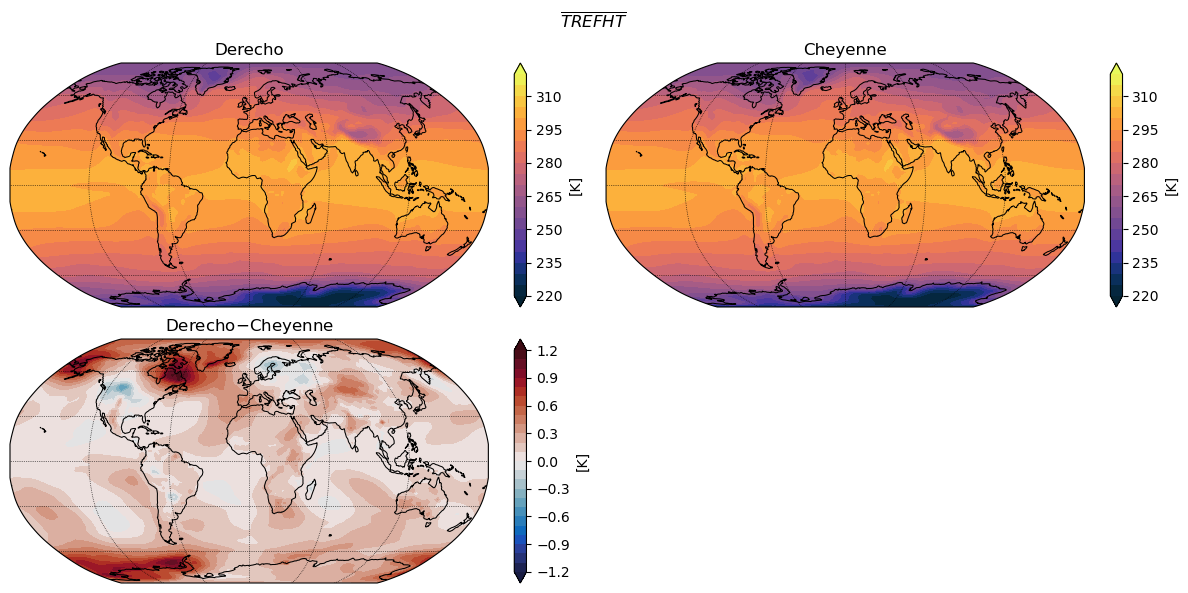

In [109]:
levels_raw = np.arange(220,321,5)
levels_diff = np.arange(-1.2,1.21,0.1)

plot_maps('TREFHT', 'atm', levels_raw, levels_diff)

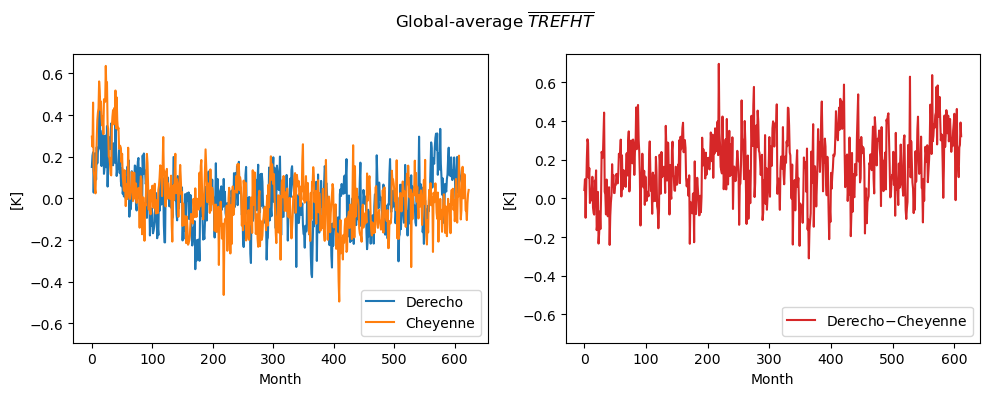

In [113]:
plot_tseries('TREFHT', 'atm')

# Surface pressure (atm)

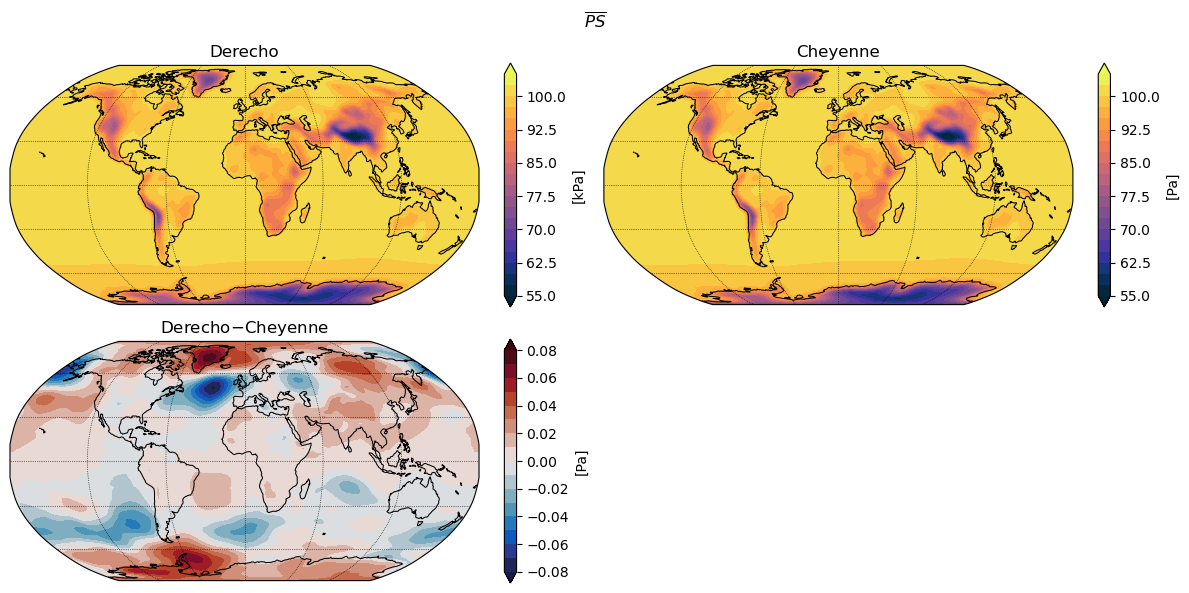

In [119]:
levels_raw = np.arange(55,106,2.5)
levels_diff = np.arange(-0.08,0.081,0.01)

plot_maps('PS', 'atm', levels_raw, levels_diff, convfactor=1e-3, units='kPa')

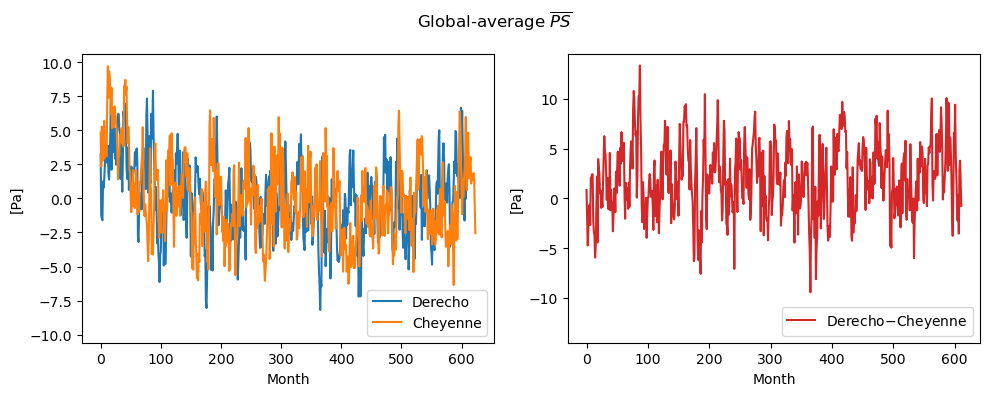

In [115]:
plot_tseries('PS', 'atm')

# Precipitation (atm)

In [ ]:
levels_raw = np.arange(55,106,2.5)
levels_diff = np.arange(-0.08,0.081,0.01)

plot_maps('PS', 'atm', levels_raw, levels_diff, convfactor=1e-3, units='mm day$^{-1}$')

In [ ]:
plot_tseries('PS', 'atm')

# Surface heat fluxes (atm)

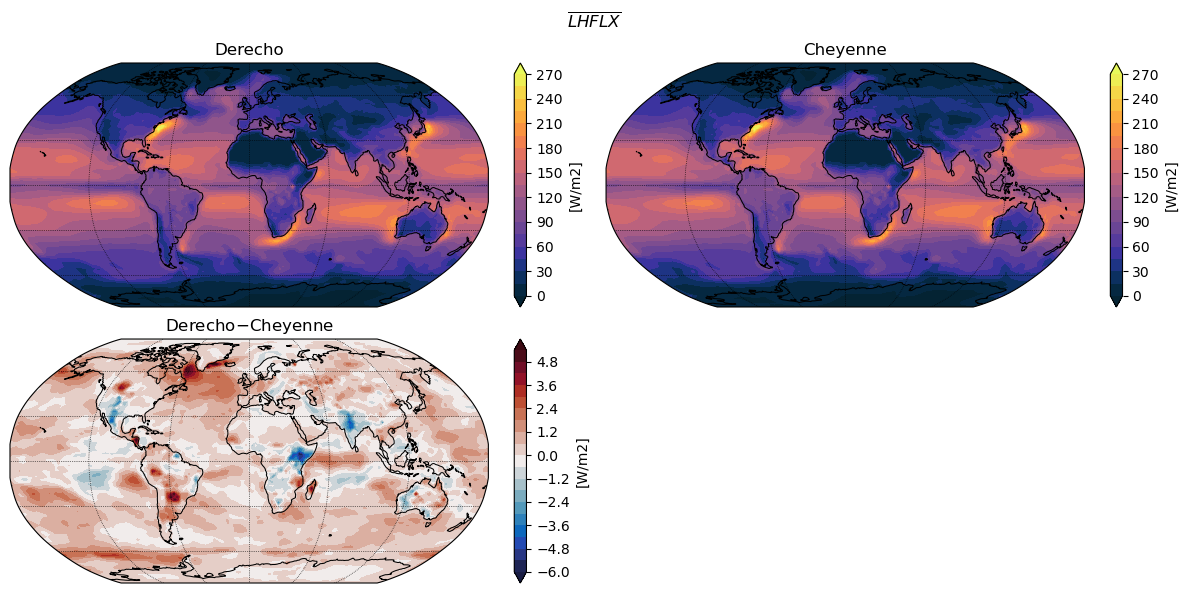

In [125]:
levels_raw = np.arange(55,106,2.5)
levels_diff = np.arange(-0.08,0.081,0.01)

# plot_maps('LHFLX', 'atm', levels_raw, levels_diff, convfactor=1e-3, units='mm day$^{-1}$')
plot_maps('LHFLX', 'atm')

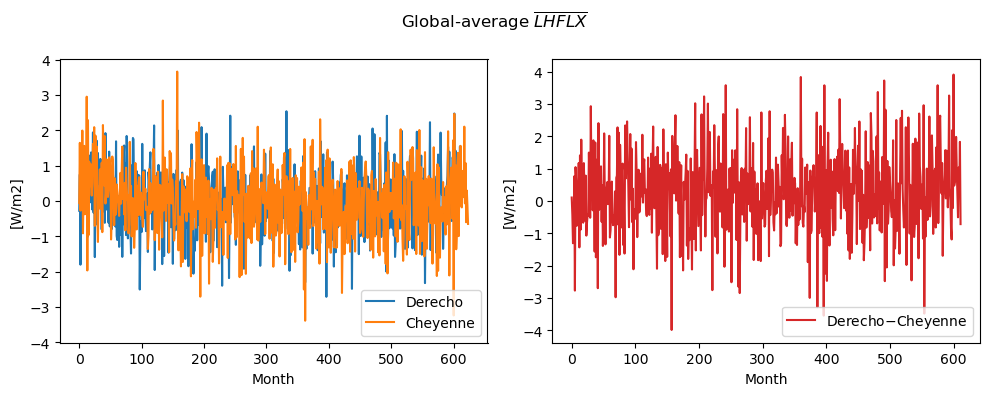

In [126]:
plot_tseries('LHFLX', 'atm')

# LAI (lnd)

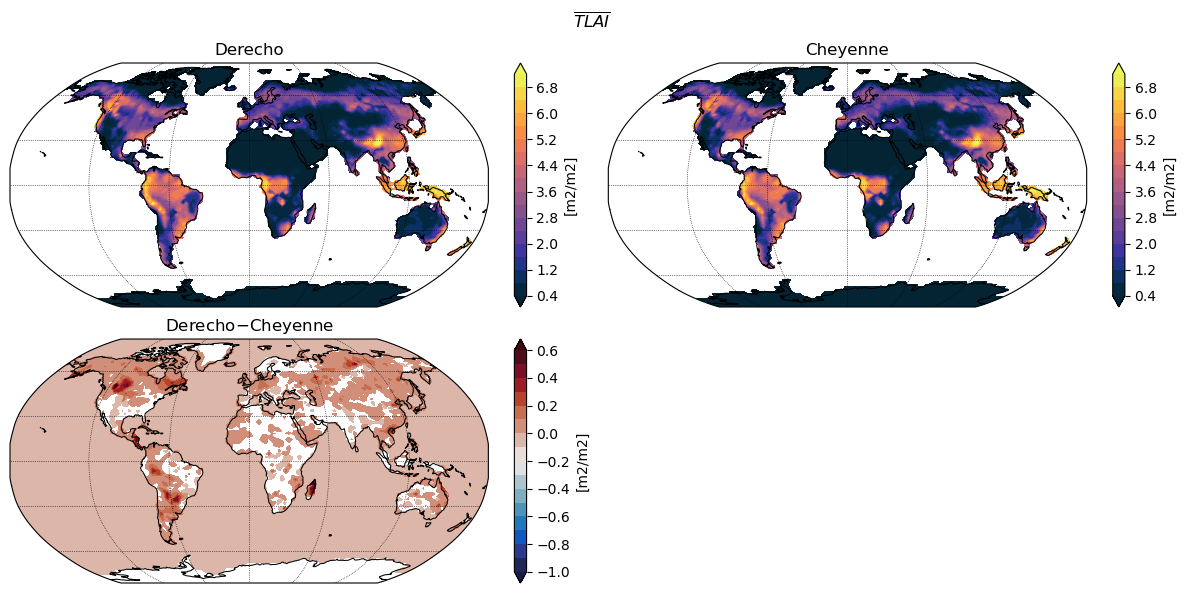

In [127]:
levels_raw = np.arange(55,106,2.5)
levels_diff = np.arange(-0.08,0.081,0.01)

# plot_maps('PS', 'atm', levels_raw, levels_diff, convfactor=1e-3, units='mm day$^{-1}$')
plot_maps('TLAI', 'lnd')

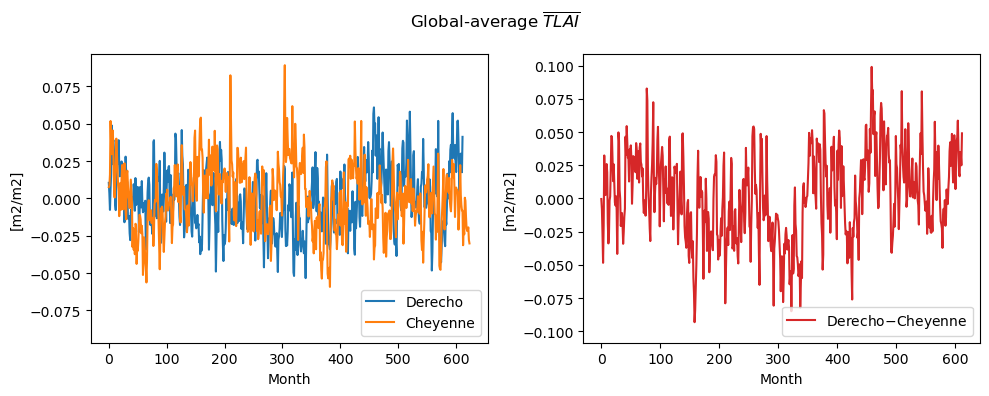

In [128]:
plot_tseries('TLAI', 'lnd')

# Canopy transpiration (lnd)

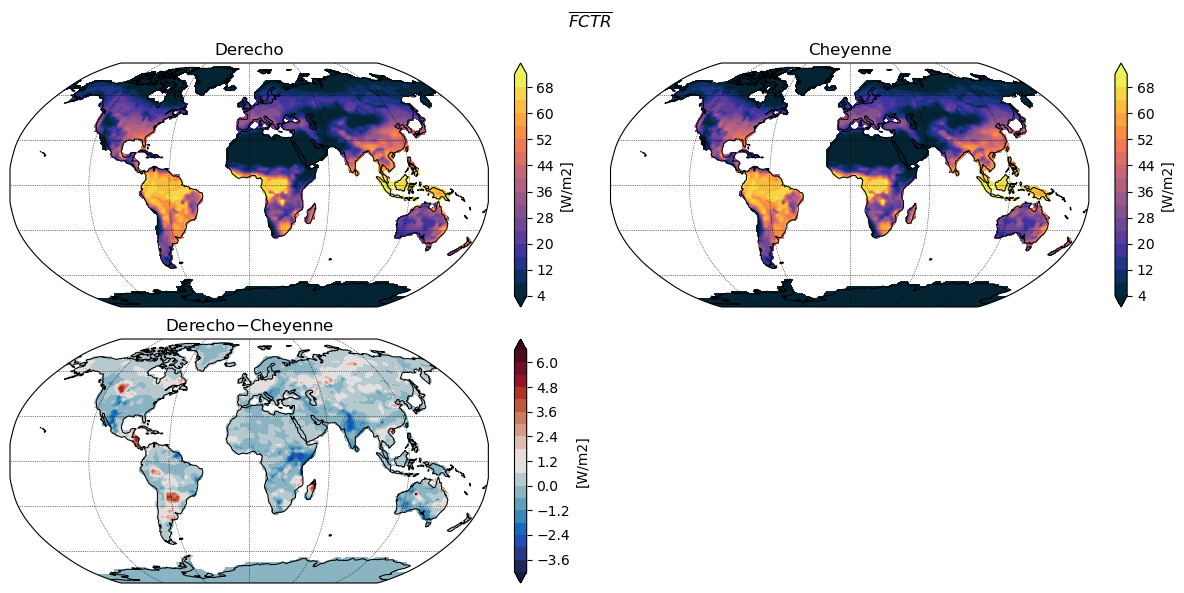

In [129]:
levels_raw = np.arange(55,106,2.5)
levels_diff = np.arange(-0.08,0.081,0.01)

# plot_maps('PS', 'atm', levels_raw, levels_diff, convfactor=1e-3, units='mm day$^{-1}$')
plot_maps('FCTR', 'lnd')

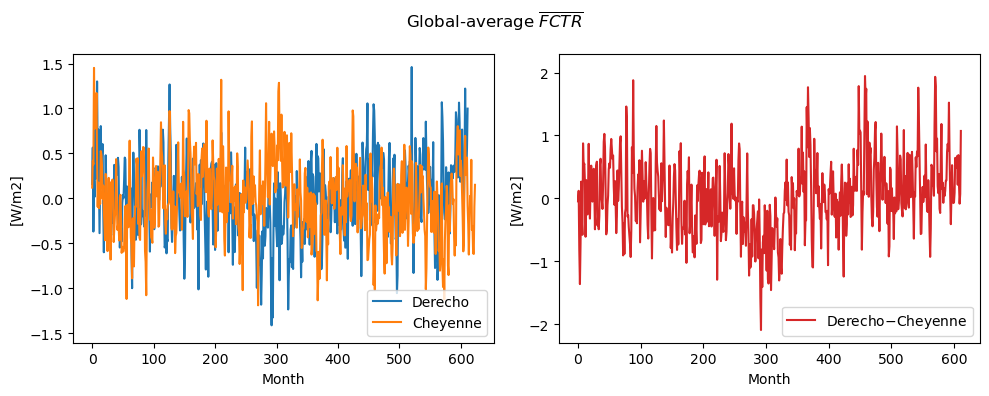

In [131]:
plot_tseries('FCTR', 'lnd')

# Stomatal conductance (lnd)

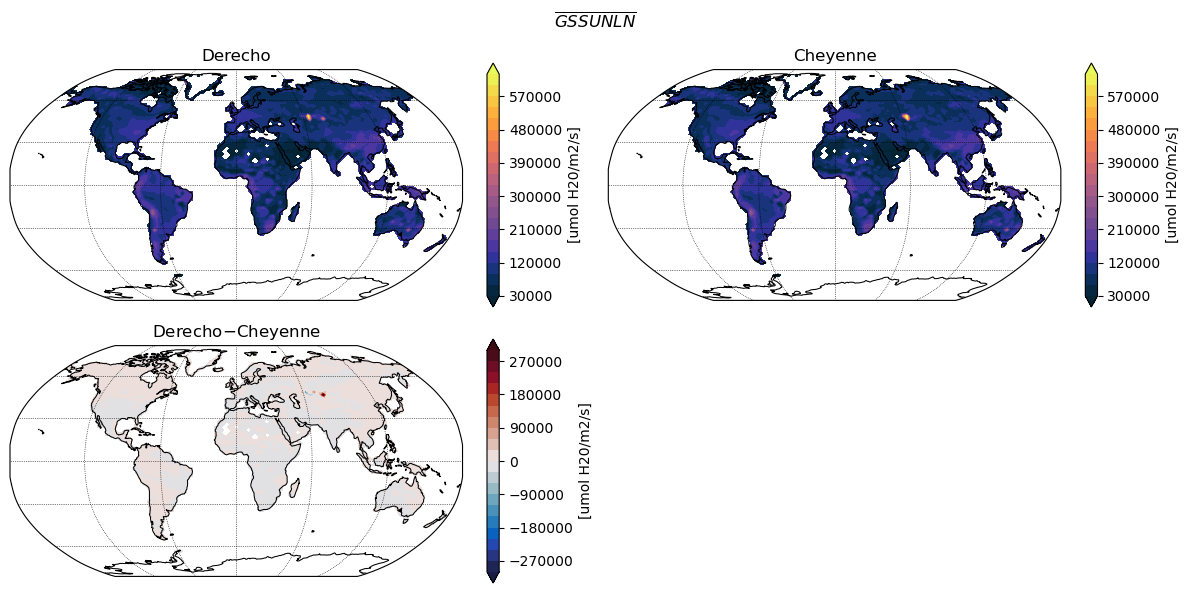

In [134]:
levels_raw = np.arange(55,106,2.5)
levels_diff = np.arange(-0.08,0.081,0.01)

# plot_maps('PS', 'atm', levels_raw, levels_diff, convfactor=1e-3, units='mm day$^{-1}$')
plot_maps('GSSUNLN', 'lnd')

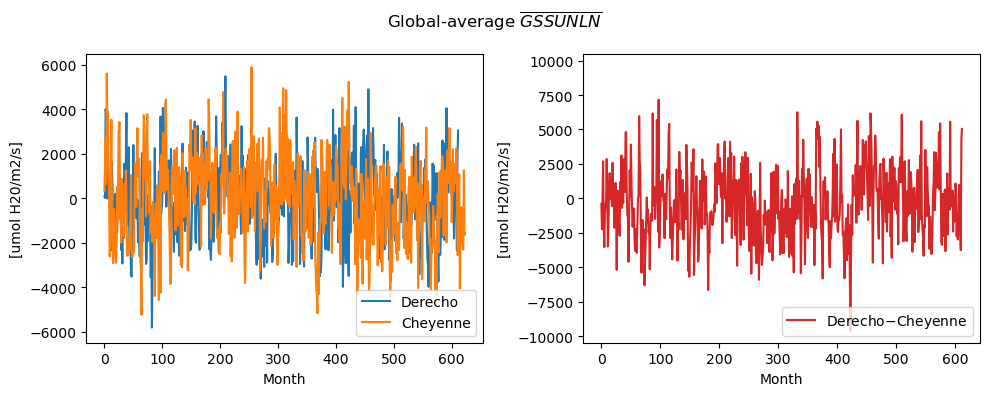

In [135]:
plot_tseries('GSSUNLN', 'lnd')